# Data Reconciliation of a Supercritical Coal-Fired Boiler, Flowsheet  Example

This notebook demonstrates data reconciliation with a flowsheet heat exchanger network, the boiler subflowsheet consist of an economizer, water wall, primary superheater, platen superheater, finishing superheater, and reheater.  Data for this example was generated by adding noise to supercritical power plant simulations.

### Why reconcile data?

Data reconciliation uses mass and energy balances along with redundant measurements to improve data quality by:

1. reducing measurement error,
2. ensuring measurements satisfy mass and energy balances, and
3. filling in unmeasured quantities.

Data reconciliation is used to refine process data before parameter estimation.

## 1.  Read Plant Data

The first step is to read in process data.  In this case, data was simulated by adding measurement error to supercritical steam cycle simulation results.  IDAES includes functions to read process data, convert units to match the models, and map data to the model.

In [1]:
# IDAES module with functions to read, analyze and visualize plant data
import idaes.dmf.model_data as da

Process data is contained in two csv files, a data file and a metadata file.  The data file where the first column is row indexes and the first row is process measurement tags.  The index column has an entry for each data row, and is often a timestamp.  The metadata file contains information about the tags including units of measurement, description, and model mapping information.

Once the process data is read in, the data is assigned to bins based on the value in a given column, in this case gross power. Dividing the data into bins allows rough estimation of measurement uncertainty.

In [2]:
# Read in data and column metadata
df, df_meta = da.read_data("plant_data.csv", "plant_data_meta.csv")
# Add bin information where the data is sorted into 5 MW bins based on the "GROSS_POWER" column
bin_count = da.bin_data(df, bin_by="POWER_GROSS", bin_no="bin_no", bin_nom="bin_power", bin_size=5e6)
# Calculate the standard deviation by bin for each column
bin_stdev = da.bin_stdev(df, bin_no="bin_no")

It can be useful to visualize the measurement data and estimated uncertainty.  The following creates box and whisker plots for each tag based on the data bins.

In [3]:
# Create a pdf book of plots that shows box and whisker plots for each column by bin
import os
if not os.path.isfile("data_plot_book.pdf"):
    da.data_plot_book(df, file="data_plot_book.pdf", bin_nom="bin_power", xlabel="gross power (W)", metadata=df_meta)
# There should now be a data_plot_book.pdf file in this directory

## 2.  Boiler Flowsheet Setup

Now that we have the plant data, we need to create the flowsheet model that we can use for data reconciliation. Although we need a model that has just mass and energy balances and feasibility constraints for the data reconciliation problem, we start with the boiler flowsheet model here.  Using the same model for data reconciliation, parameter estimation, validation, and simulation reduces the work required to move between steps in the workflow.

Once the full flowsheet model is created, constraints that are not needed for data reconciliation can be deactivated.

### 2.1 Case Study:
In a supercritical coal-fired power plant, the boiler sub-system consists of multiple heat exchangers transferring heat from the combustion side to the water/steam side. The boiler system for this work (Figure 1) is based on a 550 MWe supercritical power plant. Note that water wall and platen superheater are modeled as a heater, while the rest of the units correspond to the shell and tube heat exchangers.
Note that boiler flowsheet block diagram shows the available measurements from plant data. *for demonstration purposes "plant data" has been trained at different operating loads and with noise. 

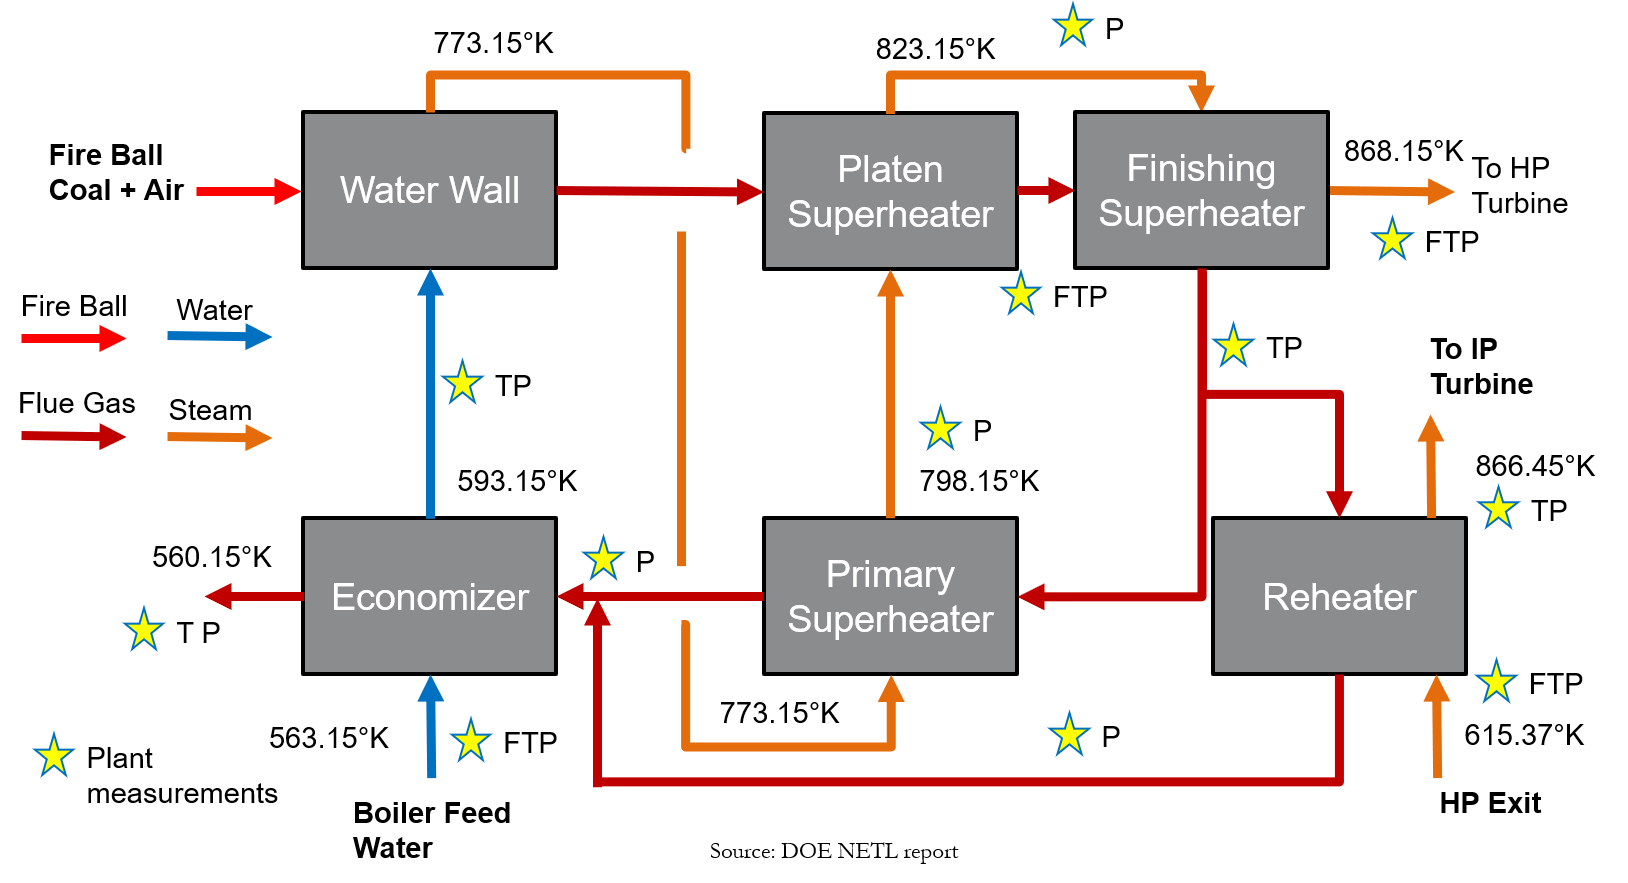

In [4]:
from IPython.display import Image
Image("boiler_flowsheet.png")

In [5]:
# Import pyomo and idaes libraries
# import idaes flowsheet object
from idaes.core import FlowsheetBlock
# import flue gas property package
from idaes.power_generation.properties.IdealProp_FlueGas import FlueGasParameterBlock
# import utility to report degrees of freedom
from idaes.core.util.model_statistics import degrees_of_freedom
# import water/steam property package and functions to calculate enthalpy
from idaes.generic_models.properties import iapws95
# import unit models from power generation library
from idaes.power_generation.unit_models.boiler_heat_exchanger import (
    BoilerHeatExchanger, 
    TubeArrangement, 
    DeltaTMethod
)
import pyomo.environ as pyo
# import methods to build the flowsheet and deactivate performance constraints
import boiler_data_rec as flowsheet

### 2.2 Flowsheet Setup
The "boiler_flowsheet" method imports all the unit models in the boiler heat exchanger network, builds the flowsheet, builds the flowsheet connectivity, and initializes the flowsheet.

The final solve corresponds to a simulation case, with the following inputs (relative to a ~650 MW case):
- Econommizer (water): F, h, P
- Reheater Inlet (Cold Reheat steam): F, h, P
- Coal flowrate (kg/s) and stoichiometric ratio (unitless)
- Dimensions of all units (tube diameter, # tubes, hx area, etc.)

In [6]:
# Create boiler flowsheet, the main unit models are: 
# heat exchanger model: economizer, primary super heater, finishing superheater, and reheater
# heater model: water wall and platen superheater

m = flowsheet.boiler_flowsheet()

57072.56349970795
60200.651879780475
2020-06-25 15:10:47 [INFO] idaes.init.fs.ECON.side_1: Initialization Complete
Ipopt 3.13.2: tol=1e-06
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    con

Total number of equality constraints.................:        8
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  0.0000000e+00 4.44e-16 0.00e+00  -1.0 5.00e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   4.4408920985006262e-16    4.4408920985006262e-16
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:  

Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
2020-06-25 15:10:48 [INFO] idaes.power_generation.unit_models.boiler_heat_exchanger: fs.ECON Initialisation Step 2 Complete.
Ipopt 3.13.2: tol=1e-06
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All techn

Ipopt 3.13.2: tol=1e-06
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        c

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        9
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.00e+02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  0.0000000e+00 0.00e+00 0.00e+00  -1.0 1.33e+05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
   2  0.0000000e+00 1.91e+04 1.56e+01  -1.0 1.69e+07    -  7.85e-01 5.00e-01h  2
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
   3  0.0000000e+00 9.53e+03 4.08e+00  -1.0 3.21e+06    -  9.88e-01 5.00e-01h  2
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
   4  0.0000000e+00 4.76e+03 1.99e+00  -1.0 3.69e+05    -  9.90e-01 5.00e-01h  2
   5  0.0000000e+00 2.72e+00 9.59e-02  -1.0 9.65e+04    -  9.90e-01 1.00e+00h  1
   6  0.0000000e+00 2.36e-01 1.65e-02  -1.0 2.62e+04    -  9.91e-01 1.00e+00h  1
   7  0.0000000e+00 1.79e-03 2.50e-04  -1.0 2.70e+03    -  1.00e+00 1.00e+00h  1
   8  0.0000000e+00 1.03e-07 2.45e-08  -2.5 2.08e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility

2020-06-25 15:10:49 [INFO] idaes.unit_model.properties: fs.FSH.side_2.properties_in Initialisation Step 2 Complete.
2020-06-25 15:10:49 [INFO] idaes.unit_model.properties: fs.FSH.side_2.properties_in Initialisation Complete.
Ipopt 3.13.2: tol=1e-06
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All te

        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://www.hsl.rl.ac.uk.
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:      414
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      633

Total number of variables............................:      119
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
Total number of equality constraints.................:      119
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints 

   2  0.0000000e+00 2.56e+00 0.00e+00  -1.0 7.26e+00    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 4.67e-01 0.00e+00  -1.0 2.43e+00    -  1.00e+00 1.00e+00h  1
   4  0.0000000e+00 2.65e-03 0.00e+00  -3.8 4.67e-01    -  1.00e+00 1.00e+00h  1
   5  0.0000000e+00 5.82e-11 0.00e+00  -3.8 2.65e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   4.6551656111371240e-13    5.8207660913467407e-11
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.6551656111371240e-13    5.8207660913467407e-11


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequal

2020-06-25 15:10:50 [INFO] idaes.unit_model.properties: fs.RH.side_2.properties_out Initialisation Step 1 Complete.
Ipopt 3.13.2: tol=1e-06
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    co

2020-06-25 15:10:51 [INFO] idaes.power_generation.unit_models.boiler_heat_exchanger: fs.RH Initialisation Step 2 Complete.
Ipopt 3.13.2: tol=1e-06
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must

2020-06-25 15:10:51 [DEBUG] idaes.solve.fs.PlSH: Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
2020-06-25 15:10:51 [DEBUG] idaes.solve.fs.PlSH: Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
2020-06-25 15:10:51 [DEBUG] idaes.solve.fs.PlSH: Overall NLP error.......:   0.0000000000000000e+00    0.0000000000000000e+00
2020-06-25 15:10:51 [DEBUG] idaes.solve.fs.PlSH: Number of objective function evaluations             = 2
2020-06-25 15:10:51 [DEBUG] idaes.solve.fs.PlSH: Number of objective gradient evaluations             = 2
2020-06-25 15:10:51 [DEBUG] idaes.solve.fs.PlSH: Number of equality constraint evaluations            = 2
2020-06-25 15:10:51 [DEBUG] idaes.solve.fs.PlSH: Number of inequality constraint evaluations          = 0
2020-06-25 15:10:51 [DEBUG] idaes.solve.fs.PlSH: Number of equality constraint Jacobian evaluations   = 2
2020-06-25 15:10:51 [DEBUG] idaes.solve.fs.PlSH: Number of inequality constraint Jacobian ev

Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 1
Total CPU secs in IPOPT (w/o function evaluations)   =      0.001
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
2020-06-25 15:10:51 [INFO] idaes.unit_model.properties: fs.Spl1.mixed_state Initialisation Step 1 Complete.
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/id

   0  0.0000000e+00 9.09e-13 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0

Number of Iterations....: 0

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   7.2736962674017562e-15    9.0949470177292824e-13
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   7.2736962674017562e-15    9.0949470177292824e-13


Number of objective function evaluations             = 1
Number of objective gradient evaluations             = 1
Number of equality constraint evaluations            = 1
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total CPU secs in IPOPT (w/o fun

2020-06-25 15:10:52 [DEBUG] idaes.solve.fs.Spl1: This program contains Ipopt, a library for large-scale nonlinear optimization.
2020-06-25 15:10:52 [DEBUG] idaes.solve.fs.Spl1: Ipopt is released as open source code under the Eclipse Public License (EPL).
2020-06-25 15:10:52 [DEBUG] idaes.solve.fs.Spl1: For more information visit http://projects.coin-or.org/Ipopt
2020-06-25 15:10:52 [DEBUG] idaes.solve.fs.Spl1: This version of Ipopt was compiled from source code available at
2020-06-25 15:10:52 [DEBUG] idaes.solve.fs.Spl1: https://github.com/IDAES/Ipopt as part of the Institute for the Design of
2020-06-25 15:10:52 [DEBUG] idaes.solve.fs.Spl1: Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
2020-06-25 15:10:52 [DEBUG] idaes.solve.fs.Spl1: Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.
2020-06-25 15:10:52 [DEBUG] idaes.solve.fs.Spl1: This version of Ipopt was compiled using HSL, a collection of Fortran codes
2020-06-25 15:10:52 [DEBUG

2020-06-25 15:10:52 [INFO] idaes.unit_model.properties: fs.mix1.Reheat_out_state Initialisation Step 1 Complete.
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknow

Number of objective gradient evaluations             = 2
Number of equality constraint evaluations            = 2
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 2
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 1
Total CPU secs in IPOPT (w/o function evaluations)   =      0.002
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
2020-06-25 15:10:52 [INFO] idaes.unit_model.properties: fs.mix1.PrSH_out_state Initialisation Step 2 Complete.
2020-06-25 15:10:52 [INFO] idaes.unit_model.properties: fs.mix1.PrSH_out_state Initialisation Complete.
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more informati

2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.mix1: Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.mix1: Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.mix1: This version of Ipopt was compiled using HSL, a collection of Fortran codes
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.mix1: for large-scale scientific computation.  All technical papers, sales and
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.mix1: publicity material resulting from use of the HSL codes within IPOPT must
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.mix1: contain the following acknowledgement:
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.mix1: HSL, a collection of Fortran codes for large-scale scientific
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.mix1: computation. See http://www.hsl.rl.ac.uk.
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.mix1: *********************************************

2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.ATMP1: ******************************************************************************
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.ATMP1: This is Ipopt version 3.13.2, running with linear solver ma27.
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.ATMP1: Number of nonzeros in equality constraint Jacobian...:        8
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.ATMP1: Number of nonzeros in inequality constraint Jacobian.:        0
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.ATMP1: Number of nonzeros in Lagrangian Hessian.............:        2
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.ATMP1: Total number of variables............................:        5
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.ATMP1: variables with only lower bounds:        0
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.ATMP1: variables with lower and upper bounds:        2
2020-06-25 15:10:53 [DEBUG] idaes.solve.fs.ATMP1: variables with only upper bounds:        0
2020-06-25 15:10:5

degrees of freedom = 0


In [7]:
import pytest
assert pyo.value(m.fs.coal_flow) == pytest.approx(50.15, rel=1e-4)
assert pyo.value(m.fs.PlSH.heat_duty[0]) == pytest.approx(88880834.87, rel= 1e-3)

## 3.  Simplify to Mass and Energy Balances

For data reconciliation, the flowsheet model should be reduced to mass and energy balances and potentially limited performance constraints to keep the results feasible.

In [8]:
# Deactivate constraints for heat transfer (for all heat exchanger units)
# for example to deactivate heat trasnfer calculation in the economizer we include:
# m.fs.ECON.overall_heat_transfer_coefficient_eqn.deactivate()

# The method "deactivate_performance_constraints" deactivates the equations for all 
# heat exchangers in this flowsheet (Economizer, Primary Superheater, 
#                                    Finishing Superheater, Reheater)
flowsheet.deactivate_performance_constraints(m)

# Now the model has 12 DoF 
# deltaP shell and tube, and U - overall heat transfer coefficient in 4 hx models

degrees of freedom = 12


In [9]:
assert degrees_of_freedom(m) == pytest.approx(12, rel=1e-4)

## 4. Map Data to the Model

Although the model mapping can be added to the tag metadata file, here we just add the mapping information to the tag metadata after reading the data.

In [10]:
# Water/Steam Measurements ----------------------------------------------- #
# Economizer inputs
df_meta["BFW_F"]["reference_string"] = "m.fs.ECON.side_1.properties_in[:].flow_mol"
df_meta["BFW_T"]["reference_string"] = "m.fs.ECON.side_1.properties_in[:].temperature"
df_meta["BFW_P"]["reference_string"] = "m.fs.ECON.side_1.properties_in[:].pressure"

# Economizer outputs
df_meta["ECON_OUT_T"]["reference_string"] = "m.fs.ECON.side_1.properties_out[:].temperature"
df_meta["ECON_OUT_P"]["reference_string"] = "m.fs.ECON.side_1.properties_out[:].pressure"

# Reheater inputs 
df_meta['RHT_COLD_T']["reference_string"] = "m.fs.RH.side_1.properties_in[:].temperature"
df_meta['RHT_COLD_P']["reference_string"] = "m.fs.RH.side_1.properties_in[:].pressure"
df_meta['RHT_COLD_F']["reference_string"] = "m.fs.RH.side_1.properties_in[:].flow_mol"

# Reheater outputs 
df_meta['RHT_HOT_T']["reference_string"] = "m.fs.RH.side_1.properties_out[:].temperature"
df_meta['RHT_HOT_P']["reference_string"] = "m.fs.RH.side_1.properties_out[:].pressure"

# primary SH outlet
df_meta['PlatenSH_IN_P']["reference_string"] = "m.fs.PrSH.side_1.properties_out[:].pressure"

# Platen SH outlet inlet to Finishing SH
df_meta['FSH_In_P']["reference_string"] = "m.fs.PrSH.side_1.properties_in[:].pressure"

# Finishing SH outlet ----------------------------------------------------- #
# Main Steam 
df_meta['MS_T']["reference_string"] = "m.fs.ATMP1.mixed_state[:].temperature"
df_meta['MS_P']["reference_string"] = "m.fs.ATMP1.mixed_state[:].pressure"
df_meta['MS_F']["reference_string"] = "m.fs.ATMP1.mixed_state[:].flow_mol"

# Flue Gas measurements
# Finishing inputs
df_meta['FG_2_FSH_Fm']["reference_string"] = "m.fs.FSH.side_2.properties_in[:].flow_mass"
df_meta['FG_2_FSH_T']["reference_string"] = "m.fs.FSH.side_2.properties_in[:].temperature"
df_meta['FG_2_FSH_P']["reference_string"] = "m.fs.FSH.side_2.properties_in[:].pressure"

# Reheater inputs
df_meta['FG_2_RH_T']["reference_string"] = "m.fs.RH.side_2.properties_in[:].temperature"
df_meta['FG_2_RH_P']["reference_string"] = "m.fs.RH.side_2.properties_in[:].pressure"

# Primary SH inputs
df_meta['FG_2_PrSH_Fm']["reference_string"] = "m.fs.PrSH.side_2.properties_in[:].flow_mass"
df_meta['FG_2_PrSH_T']["reference_string"] = "m.fs.PrSH.side_2.properties_in[:].temperature"
df_meta['FG_2_PrSH_P']["reference_string"] = "m.fs.PrSH.side_2.properties_in[:].pressure"

# Economizer inputs
df_meta["FG_2_ECON_P"]["reference_string"] = "m.fs.ECON.side_2.properties_in[:].pressure"

# Economizer outputs
df_meta["FG_2_AIRPH_T"]["reference_string"] = "m.fs.ECON.side_2.properties_out[:].temperature"
df_meta["FG_2_AIRPH_P"]["reference_string"] = "m.fs.ECON.side_2.properties_out[:].pressure"

# --------------------------------------------------------------------------------------- #
# Other inputs available in the data set (but not used as measurements in this study)
df_meta["ECON_OUT_F"]["reference_string"] = "m.fs.ECON.side_1.properties_out[:].flow_mol"
df_meta['RHT_HOT_F']["reference_string"] = "m.fs.RH.side_1.properties_out[:].flow_mol"
df_meta['FG_2_RH_Fm']["reference_string"] = "m.fs.RH.side_2.properties_in[:].flow_mass"
df_meta["FG_2_ECON_Fm"]["reference_string"] = "m.fs.ECON.side_2.properties_in[:].flow_mass"
df_meta["FG_2_ECON_T"]["reference_string"] = "m.fs.ECON.side_2.properties_in[:].temperature"
df_meta["FG_2_AIRPH_Fm"]["reference_string"] = "m.fs.ECON.side_2.properties_out[:].flow_mass"

df_meta['FG_RH_2_Mix_Fm']["reference_string"] = "m.fs.RH.side_2.properties_out[:].flow_mass"
df_meta['FG_RH_2_Mix_T']["reference_string"] = "m.fs.RH.side_2.properties_out[:].temperature"
df_meta['FG_RH_2_Mix_P']["reference_string"] = "m.fs.RH.side_2.properties_out[:].pressure"

df_meta['FG_PrSH_2_Mix_Fm']["reference_string"] = "m.fs.PrSH.side_2.properties_out[:].flow_mass"
df_meta['FG_PrSH_2_Mix_T']["reference_string"] = "m.fs.PrSH.side_2.properties_out[:].temperature"
df_meta['FG_PrSH_2_Mix_P']["reference_string"] = "m.fs.PrSH.side_2.properties_out[:].pressure"

df_meta['FG_2_ECON_Fm']["reference_string"] = "m.fs.ECON.side_2.properties_in[:].flow_mass"
df_meta['FG_2_ECON_T']["reference_string"] = "m.fs.ECON.side_2.properties_in[:].temperature"
df_meta['FG_2_ECON_P']["reference_string"] = "m.fs.ECON.side_2.properties_in[:].pressure"

df_meta['FG_2_AIRPH_Fm']["reference_string"] = "m.fs.ECON.side_2.properties_out[:].flow_mass"
df_meta['FG_2_AIRPH_T']["reference_string"] = "m.fs.ECON.side_2.properties_out[:].temperature"
df_meta['FG_2_AIRPH_P']["reference_string"] = "m.fs.ECON.side_2.properties_out[:].pressure"

In [11]:
# Add the model references to the tag metadata based on the strings above.
da.upadate_metadata_model_references(m, df_meta)

In [12]:
# Create a dictionary of data tags that we want to use for the data reconciliation problem.  
# The key is the tag and the value is a reference to a quantity in the model.  
data_tags = {k:v["reference"][0] for k, v in df_meta.items() if v["reference"] is not None}

In [13]:
# The output from the data reconciliation step usually gives full stream information
# for a flowsheet including quantities that are unmeasured. To use the results more easily, 
# it is good practice to map most of the data reconciliation results to flowsheet stream names.
import idaes.core.util.tables as ta

stream_dict = ta.arcs_to_stream_dict(
    m, 
    additional={
        'MS': m.fs.ATMP1.mixed_state,
        'ATMP_In': m.fs.FSH.side_1.properties_out,
        'FSH_In': m.fs.FSH.side_1.properties_in,
        'PrSH_IN': m.fs.PrSH.side_1.properties_in,
        'RHT_COLD': m.fs.RH.side_1.properties_in,
        'RHT_HOT': m.fs.RH.side_1.properties_out,
        'PlatenSH_IN': m.fs.PlSH.control_volume.properties_in,
        'BFW': m.fs.ECON.side_1.properties_in,
        'ECON_OUT': m.fs.ECON.side_1.properties_out,
        'FG_2_FSH': m.fs.FSH.side_2.properties_in,
    },
    sort=True,
)

state_dict = ta.stream_states_dict(stream_dict, time_point=0)
recon_tags = ta.tag_state_quantities(
    blocks=state_dict, 
    attributes=(
        "flow_mass", 
        "flow_mol", 
        "enth_mol", 
        "temperature", 
        "pressure", 
        ("flow_component", "O2"),
        ("flow_component", "NO"),
        ("flow_component", "N2"),
        ("flow_component", "SO2"),
        ("flow_component", "CO2"),
        ("flow_component", "H2O"),
    ), 
    labels=("_Fm", "_F", "_h", "_T", "_P", "_F[O2]", "_F[NO]", "_F[N2]", "_F[SO2]", "_F[CO2]", "_F[H2O]"),
)
# add additional model variables
recon_tags["coal_flow"] = m.fs.coal_flow
recon_tags["stoich_ratio"] = m.fs.SR

## 5. View Model Flowsheet

Model results or other quantities can be added to a process flow diagram. The PFD was drawn beforehand and the model results are added to tagged locations on the PFD.

In [14]:
from idaes.core.util.misc import svg_tag  # utility to place numbers/text in an SVG

with open("boiler_scpc_PFD.svg", "r") as f:
    s = svg_tag(svg=f, tags={"subtitle":"Initialized Model"})
    s = svg_tag(svg=s, tags=data_tags, outfile="boiler_scpc_init.svg")

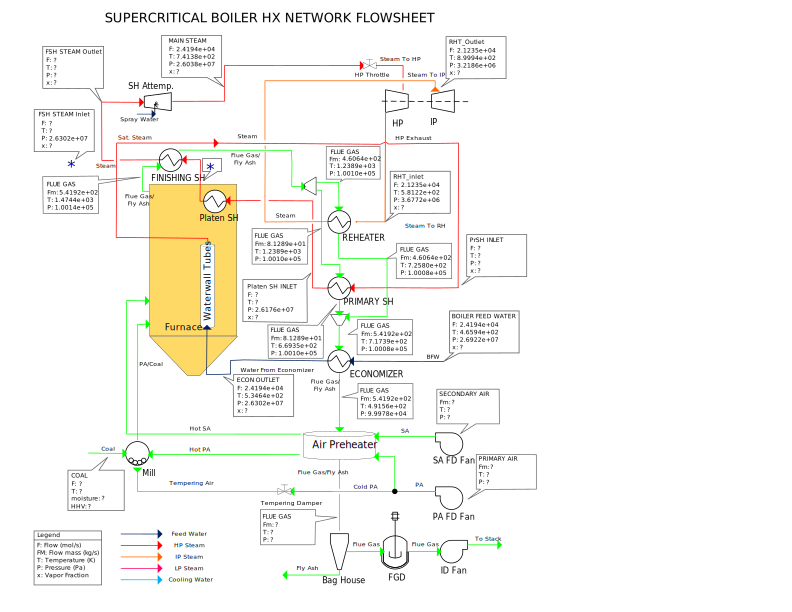

In [15]:
from IPython.display import SVG, display

display(SVG(s))

## 6.  Write Objective

Next we write the objective function and additional constraints for the data reconciliation problem.  The objective is

$$\min \sum_i \left(\frac{x_{\text{data}, i} - x_{\text{model}, i}}{\sigma_i} \right)^2$$

Where $i \in \{\text{Measured Quantities}\}$ and $\sigma_i$ is the standard deviation of measurement i estimated by binning the data.

In [16]:
# Add model parameters to contain measured data.  These are mutable so we can set a specific 
# change to specific data points later.
m.data = pyo.Param(data_tags, mutable=True, doc="Process data for a specific point in time.")
m.data_stdev = pyo.Param(data_tags, mutable=True, doc="Process data standard deviation.")

In [17]:
# The 'set_data' function below takes data from the model DataFrame and updates the
# model data parameters.
# fix tags dictionary is used to fix model inputs to their values in the data set (for each data point)
# in this case Boiler Feed Water = inlet to economizer and Reheater Cold = Reheater inlet
_fix_tags = [
    #'BFW_P',
      #      'BFW_F',  
    #'RHT_COLD_P',
            #'RHT_COLD_F',
]
def set_data(m, df, data_tags, index=None, indexindex=None):
    if index is None:
        index = df.index[indexindex]
    m.bin_no = df.iloc[index]["bin_no"]
    for t in data_tags:
        m.data[t] = df.iloc[index][t]
        m.data_stdev[t] = bin_stdev[m.bin_no][t]
    for tag in _fix_tags:
        data_tags[tag].fix(pyo.value(m.data[tag]))

In [18]:
# So we have something reasonable to start, set the data attached to the model to the first 
# data point.
set_data(m, df, data_tags, indexindex=0)

Add an expression for error divided by the standard deviation, and use it to write the data reconciliation objective function.

In [19]:
m.tags_obj = [
    'BFW_F', 
    'BFW_T', 
    'BFW_P',        
    "RHT_COLD_F", 
    "RHT_COLD_T", 
    "RHT_HOT_P",
    "ECON_OUT_T",
    "ECON_OUT_P",
    "RHT_HOT_T",
    "RHT_HOT_P",
    "MS_T", 
    "MS_P", 
    "FG_2_ECON_P",
    "FG_2_AIRPH_T",
    "FG_2_AIRPH_P",
    "FG_RH_2_Mix_T",
    "FG_RH_2_Mix_P",
    "FG_RH_2_Mix_Fm",
    "FG_2_FSH_P",
    "FG_2_FSH_T",
    "FG_PrSH_2_Mix_T",
    "FG_PrSH_2_Mix_P",
    "FG_PrSH_2_Mix_Fm",
]

@m.Expression(data_tags)
def err(m, i):
    return (m.data[i] - data_tags[i])/m.data_stdev[i]

m.objective = pyo.Objective(expr=sum(m.err[t]**2 for t in m.tags_obj))

In [20]:
# assert pyo.value(m.err["BFW_F"]) == pytest.approx(0.0, rel=1e-4)
# assert pyo.value(m.err["BFW_P"]) == pytest.approx(0.0, rel=1e-4)
# assert pyo.value(m.err["BFW_T"]) == pytest.approx(2.3, rel=1e-1)

# assert pyo.value(m.err["RHT_COLD_F"]) == pytest.approx(0.0, rel=1e-4)
# assert pyo.value(m.err["RHT_COLD_P"]) == pytest.approx(0.0, rel=1e-4)
#assert pyo.value(m.err["RHT_COLD_T"]) == pytest.approx(0.8, rel=1)

## 7. Solve Optimization

Now we need to solve the data reconciliation problem for every data point.  The important results are stored in two DataFrames ```df_result``` which contains results tagged based on model stream names to be used in the parameter estimation step and ```df_result_cmp``` which contains reconciled data based on the original measurement tags and can be used to compare the original measurements to the reconciled results.

In [21]:
# Add constraints or fix variable bounds to ensure reasonable flowsheet performance (i.e. LMTD, negative pressure drop, etc.).
# In this case, before solving the data reconciliation problem
# unfix the coal flowarate, stoichiometric ratio, and split fraction (flue gas to Reheater)

# Surrogate models have been trained using a rigorous boiler fire side model 
# with fixed wall temperature and variable fuel flowrate and stoichiometric ratio.
m.fs.coal_flow.unfix()
m.fs.coal_flow.setub(70.0)
m.fs.coal_flow.setlb(30.0)
m.fs.SR.unfix() # stoichiometric ratio 
m.fs.Spl1.split_fraction[0,'outlet_1'].unfix()

# Surrogate models are used for Flue Gas Exit Temperature, flue gas component molar flowrate,
# and heat duty to the platen superheater and water wall
m.fs.FSH.side_2.properties_in[:].temperature.unfix()
m.fs.FSH.side_2.properties_in[0].temperature.setub(1800)
m.fs.FSH.side_2.properties_in[0].temperature.setlb(1200)

# unfix flowsheet inlets
m.fs.ECON.side_1_inlet.unfix()
m.fs.RH.side_1_inlet.unfix()

In [22]:
solver = pyo.SolverFactory('ipopt')
solver.options = {'tol': 1e-6,
                   'halt_on_ampl_error': 'no',
                   'max_iter': 250}

In [23]:
import pandas as pd
# add bin information to reconciliation results so it can be used in parameter estimation
df_result = pd.DataFrame(columns=list(recon_tags.keys())+["termination", "bin_no", "bin_power"], index=df.index)
df_result_cmp = pd.DataFrame(columns=list(data_tags.keys())+["termination"], index=df.index)

for i in df.index:
    set_data(m, df, data_tags, index=i)
    ECON_T = m.data['BFW_T'].value
    ECON_P = m.data['BFW_P'].value
    hin1 = iapws95.htpx(ECON_T, ECON_P)
    m.fs.ECON.side_1.properties_in[0].enth_mol = hin1
    RH_P = m.data['RHT_COLD_P'].value
    RH_T = m.data['RHT_COLD_T'].value
    hin2 = iapws95.htpx(float(RH_T), float(RH_P))
    m.fs.RH.side_1.properties_in[0].enth_mol = hin2
    try:
        res = solver.solve(m)
        tc = str(res.solver.termination_condition)
    except:
        tc = "fail"
    df_result.iloc[i]["termination"] = tc
    df_result.iloc[i]["bin_no"] = df.iloc[i]["bin_no"]
    df_result.iloc[i]["bin_power"] = df.iloc[i]["bin_power"]
    df_result_cmp.iloc[i]["termination"] = tc
    for t in recon_tags:
        df_result.iloc[i][t] = pyo.value(recon_tags[t])
    for t in data_tags:
        df_result_cmp.iloc[i][t] = pyo.value(data_tags[t])
    print(f"{i} -- {tc}, objective: {pyo.value(m.objective)}")

0 -- optimal, objective: 2.872049709203123
1 -- optimal, objective: 7.637869535072995
2 -- optimal, objective: 2.1977028315452656
3 -- optimal, objective: 4.119665732869393
4 -- optimal, objective: 7.082927908155041
5 -- optimal, objective: 4.0549263631514485
6 -- optimal, objective: 1.4244914301995266
7 -- optimal, objective: 4.0399459884773625
8 -- optimal, objective: 2.7978558672399827
9 -- optimal, objective: 5.2531901273983825
10 -- optimal, objective: 3.4704123653550654
11 -- optimal, objective: 4.973070738443946
12 -- optimal, objective: 8.044313378425578
13 -- optimal, objective: 5.29406671020582
    model=unknown;
        message from solver=Ipopt 3.13.2\x3a Maximum Number of Iterations
        Exceeded.
14 -- maxIterations, objective: 0.29674163582865565
15 -- optimal, objective: 6.591385034813274
16 -- optimal, objective: 4.133604746568584
    model=unknown;
        message from solver=Ipopt 3.13.2\x3a Maximum Number of Iterations
        Exceeded.
17 -- maxIterations, objec

143 -- optimal, objective: 6.670409768444589
144 -- optimal, objective: 11.871394734301557
145 -- optimal, objective: 4.205586946774062
146 -- optimal, objective: 4.633678850766271
147 -- optimal, objective: 6.960266238656596
148 -- optimal, objective: 6.870466290137248
149 -- optimal, objective: 6.03106330944337
150 -- optimal, objective: 5.920113336075795
    model=unknown;
        message from solver=Ipopt 3.13.2\x3a Maximum Number of Iterations
        Exceeded.
151 -- maxIterations, objective: 8.658580443150537
152 -- optimal, objective: 1.498426191762999
153 -- optimal, objective: 1.2310551990776795
    model=unknown;
        message from solver=Ipopt 3.13.2\x3a Maximum Number of Iterations
        Exceeded.
154 -- maxIterations, objective: 4.392391594898483
155 -- optimal, objective: 10.373768587034146
    model=unknown;
        message from solver=Ipopt 3.13.2\x3a Maximum Number of Iterations
        Exceeded.
156 -- maxIterations, objective: 5.538345953202721
157 -- optimal, o

In [24]:
# Save the reconciled data to be used for parameter estimation
df_result.to_csv("boiler_plant_recon.csv")

In [25]:
# Create a new plot book to compare the original data to the reconciled data.
da.data_rec_plot_book(
    file="boiler_data_rec_plot_book.pdf",
    df_data=df, 
    df_rec=df_result_cmp,
    bin_nom="bin_power", 
    xlabel="gross power (W)", 
    metadata=df_meta
)

In [26]:
# assert algorithm works fine
assert df_result.iloc[1]["termination"] == "optimal"